In [97]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, log1p, min, col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


spark = SparkSession.builder.appName("Stress Levels Analysis").getOrCreate()
sc = spark.sparkContext


In [98]:
freq_df = spark.read.csv("../dataset/Train Data/frequency_domain_features_train.csv", header=True, inferSchema=True)
non_linear_df = spark.read.csv("../dataset/Train Data/heart_rate_non_linear_features_train.csv", header=True, inferSchema=True)
time_df = spark.read.csv("../dataset/Train Data/time_domain_features_train.csv", header=True, inferSchema=True)

# join the dataframes on the 'uuid' column
df = freq_df.join(non_linear_df, 'uuid').join(time_df, 'uuid')
df = df.drop('uuid').drop('datasetId')

df.describe().show()

+-------+------------------+------------------+-----------------+------------------+-----------------+-------------------+--------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+------------------+-------------------+-------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+
|summary|               VLF|           VLF_PCT|               LF|            LF_PCT|            LF_NU|                 HF|              HF_PCT|              HF_NU|                TP|             LF_HF|               HF_LF|               SD1|              SD2|            sampen|             higuci|    condition| 

## Condition will be mapped to a number
- 0: interruption
- 1: no stress
- 2: time pressure

In [99]:
condition_to_number ={
    'no stress': 0,
    'interruption': 1,
    'time pressure': 2,
}
with open('condition_to_number.txt', 'w') as f:
    f.write(str(condition_to_number))

In [100]:
# change the 'condition' column to numerical values
df = df.withColumn('condition', 
    when(df['condition'] == 'interruption', 0)
    .when(df['condition'] == 'no stress', 1)
    .otherwise(2)
)

df.distinct().groupBy('condition').count().show()


+---------+------+
|condition| count|
+---------+------+
|        1|200082|
|        2| 64057|
|        0|105150|
+---------+------+



In [101]:
df = df.filter((col('VLF') < 6000) & (col('LF') < 2500) & (col('HF') < 150 ) & (col('SDRR') < 420))

In [102]:
df_pd = df.toPandas()

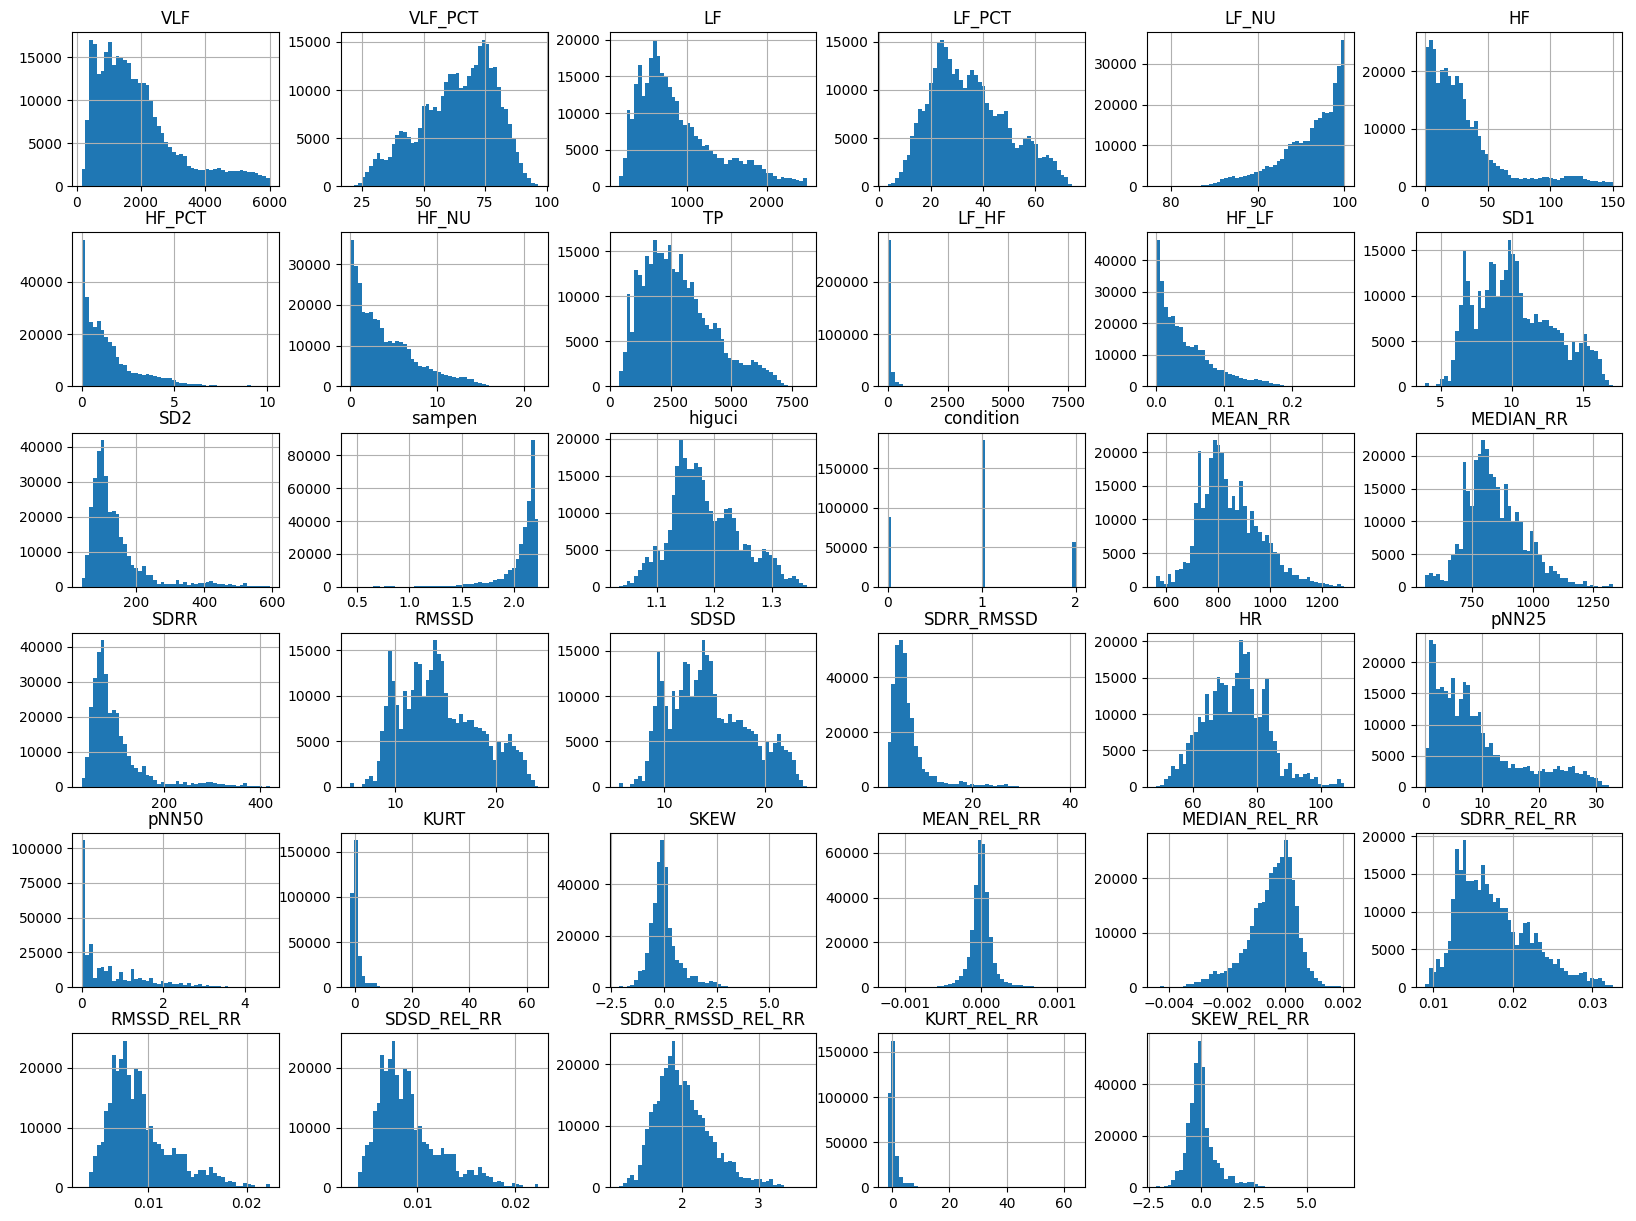

In [103]:
#change df to pandas dataframe and plot histograms
df_pd.hist(bins=50, figsize=(20, 15))
plt.show()

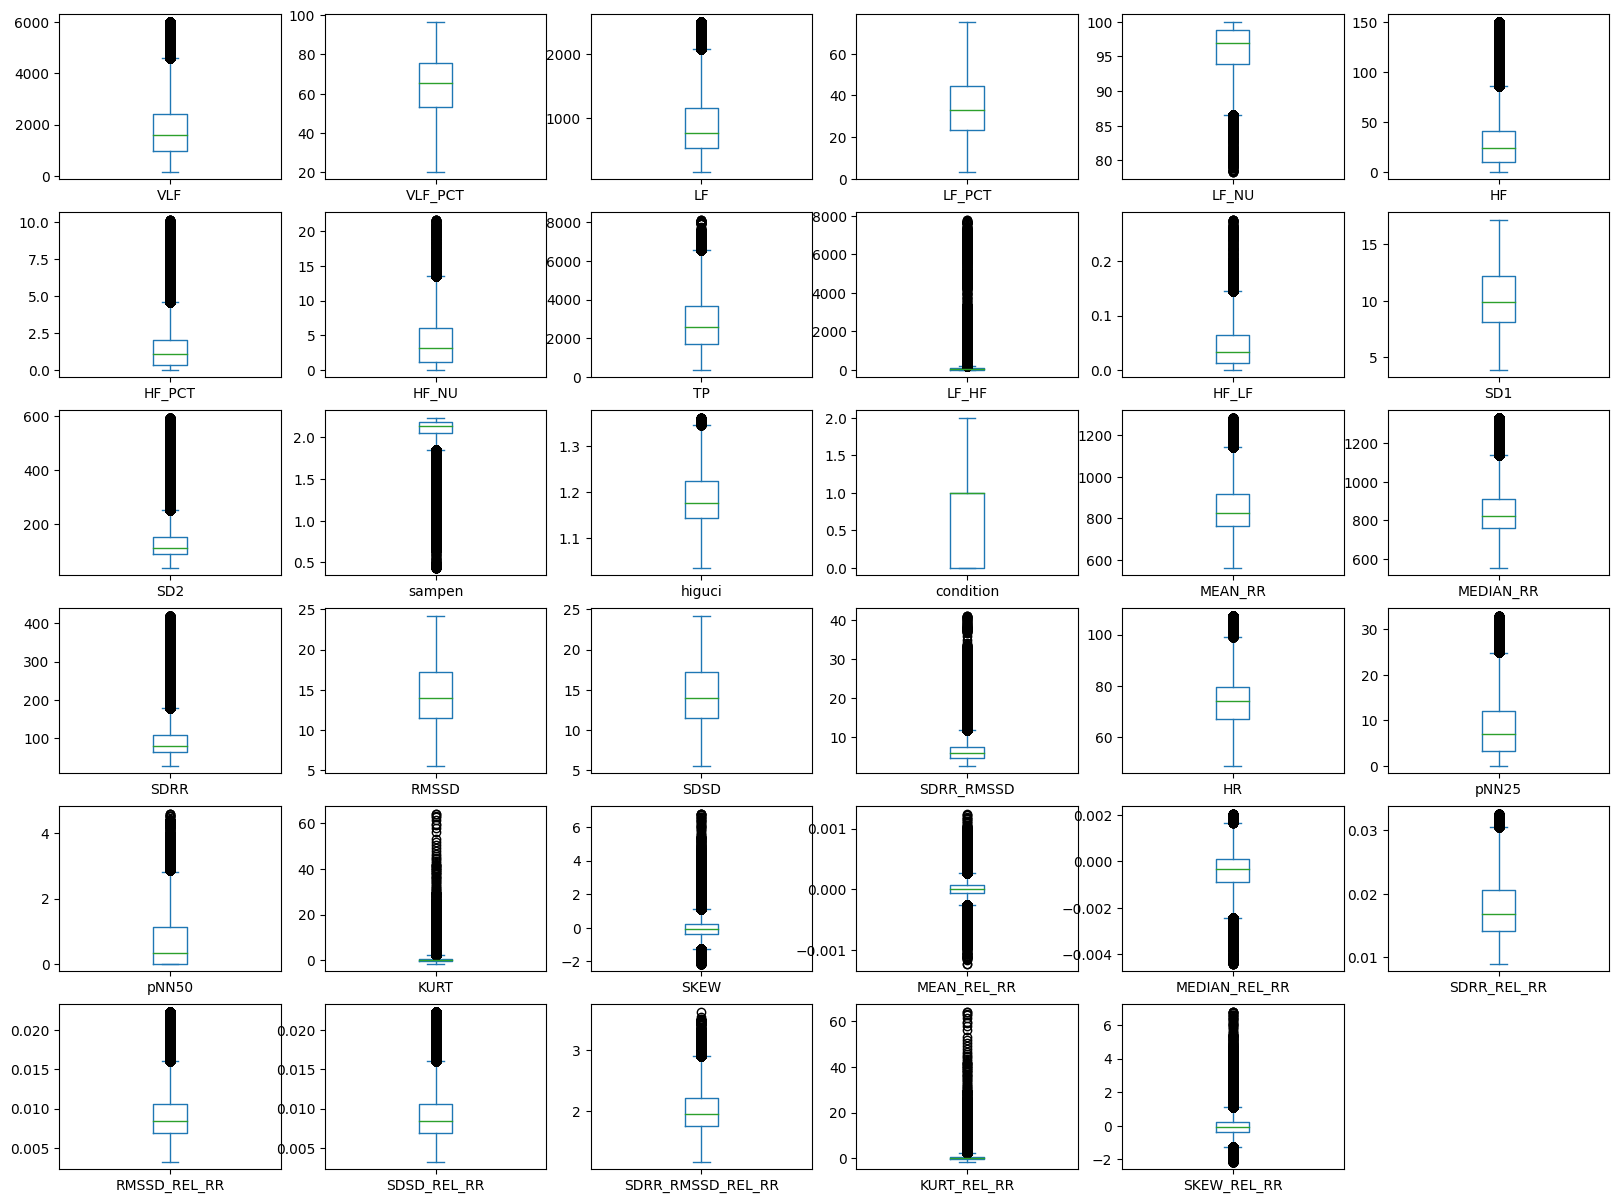

In [104]:
# draw boxplots
df_pd.plot(kind='box', subplots=True, layout=(6, 6), figsize=(20, 15))
plt.show()

In [105]:
# draw a correlation matrix
# make the condition column the last column

assembler = VectorAssembler(inputCols=df.columns, outputCol='features')
output = assembler.transform(df)
corr = Correlation.corr(output, 'features').collect()[0][0]

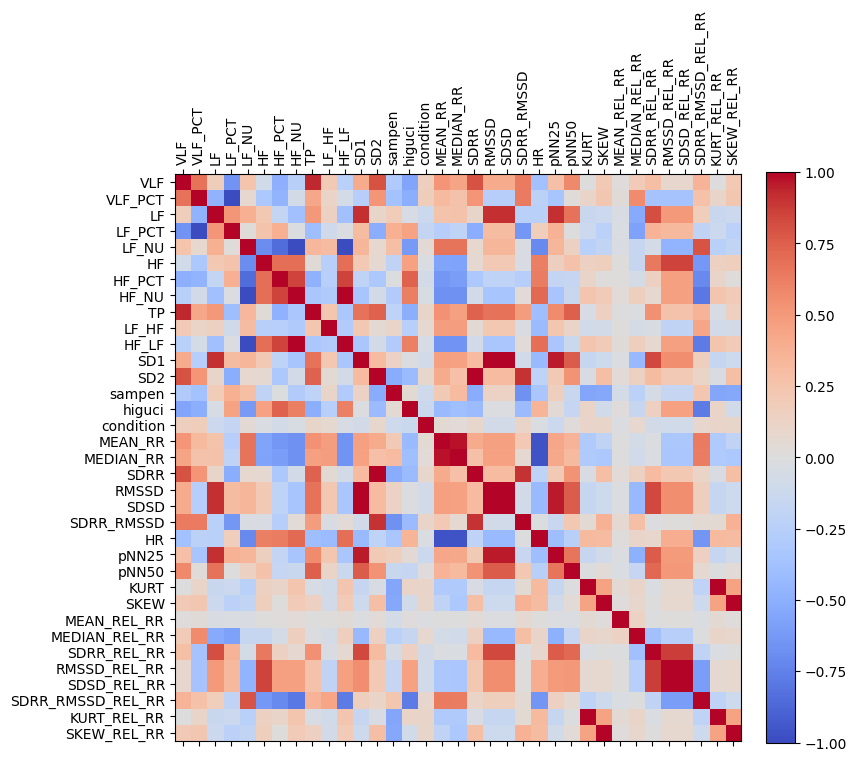

In [106]:
# plot the correlation matrix using matplotlib on big screen
# show the legend
# make the plot bigger

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(corr.toArray(), cmap='coolwarm')
plt.colorbar(cax, fraction=0.046, pad=0.04)
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)
plt.show()


In [107]:
# drop the columns with high correlation
features = df.columns
new_features = [f for f in features]
print(len(features))
for i in range(len(df.columns)):
    for j in range(i+1, len(df.columns)):
        if abs(corr.toArray()[i][j]) > 0.85:
            if features[j] in new_features:
                new_features.remove(features[j])

# new_features.remove('condition')
len(new_features) , new_features


35


(18,
 ['VLF',
  'VLF_PCT',
  'LF',
  'LF_NU',
  'HF',
  'LF_HF',
  'SD2',
  'sampen',
  'higuci',
  'condition',
  'MEAN_RR',
  'pNN50',
  'KURT',
  'SKEW',
  'MEAN_REL_RR',
  'MEDIAN_REL_RR',
  'SDRR_REL_RR',
  'SDRR_RMSSD_REL_RR'])

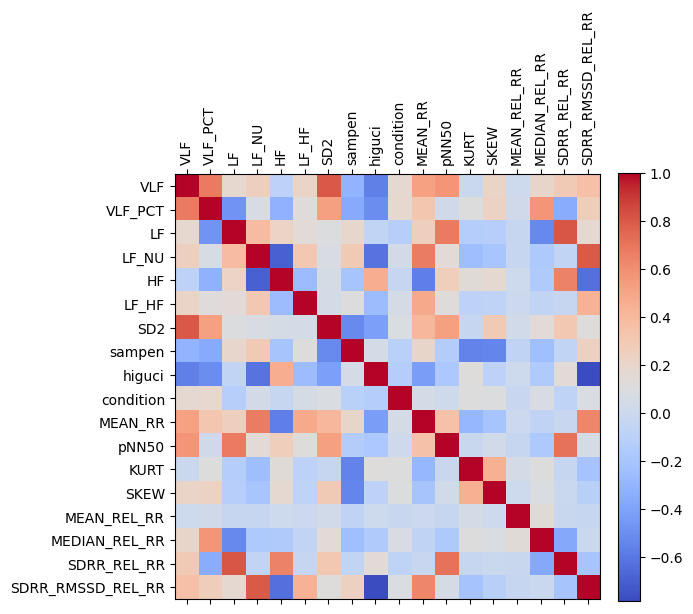

In [108]:
# print the new correlation matrix
new_df = df.select(new_features)
assembler = VectorAssembler(inputCols=new_features, outputCol='features')
output = assembler.transform(new_df)
corr = Correlation.corr(output, 'features').collect()[0][0]

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(corr.toArray(), cmap='coolwarm')
plt.colorbar(cax, fraction=0.046, pad=0.04)
plt.xticks(range(len(new_df.columns)), new_df.columns, rotation=90)
plt.yticks(range(len(new_df.columns)), new_df.columns)
plt.show()

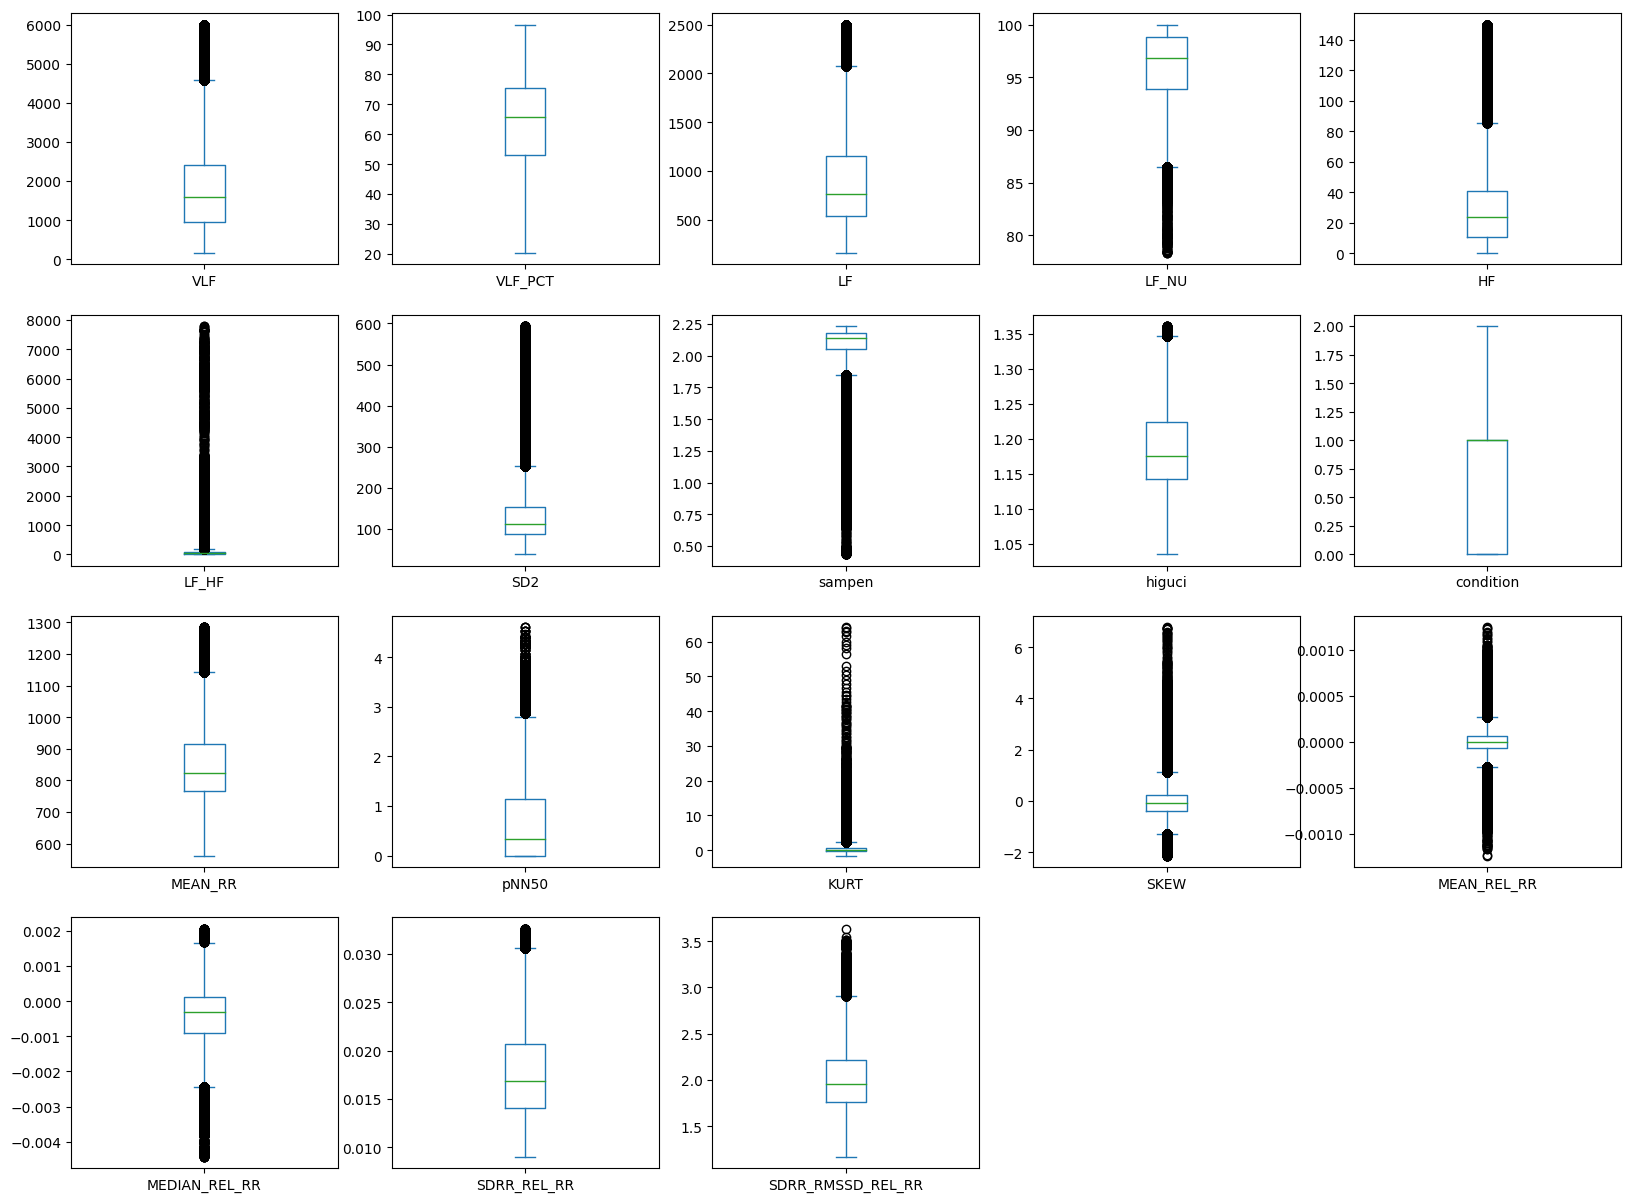

In [109]:
# show boxplots of the new dataframe
new_df_pd = new_df.toPandas()
new_df_pd.plot(kind='box', subplots=True, layout=(4, 5), figsize=(20, 15))
plt.show()

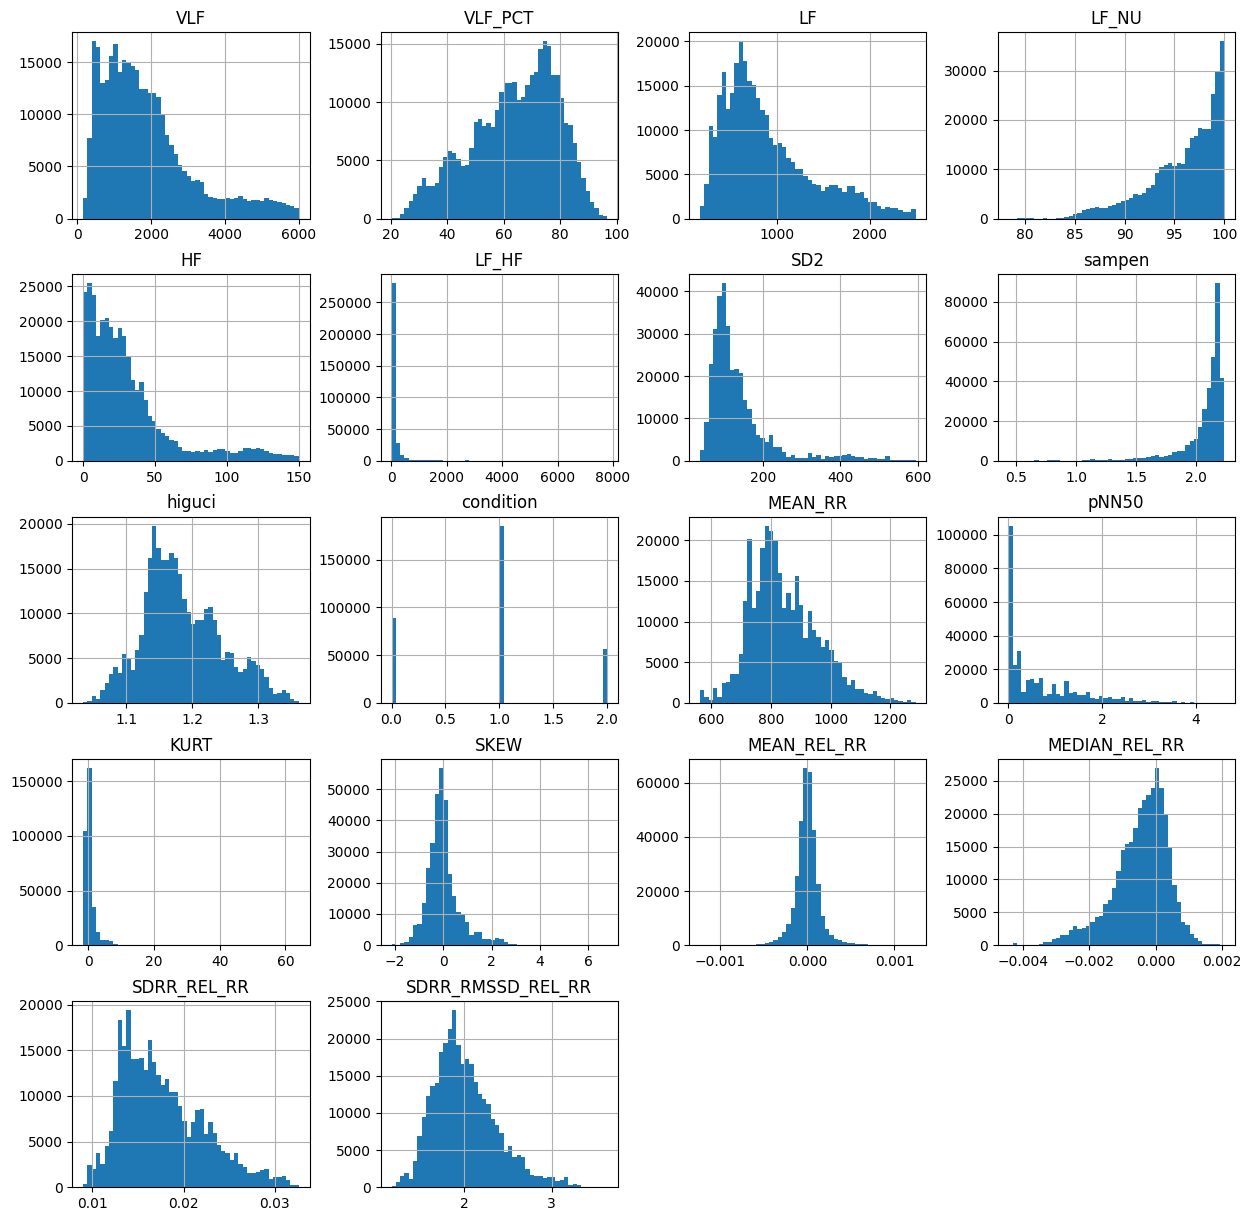

In [110]:
new_df_pd.hist(bins=50, figsize=(15, 15))
plt.show()

In [111]:
new_df_pd.shape

(330608, 18)

In [112]:
new_df_pd.columns

Index(['VLF', 'VLF_PCT', 'LF', 'LF_NU', 'HF', 'LF_HF', 'SD2', 'sampen',
       'higuci', 'condition', 'MEAN_RR', 'pNN50', 'KURT', 'SKEW',
       'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'SDRR_RMSSD_REL_RR'],
      dtype='object')

In [113]:
new_df_pd.to_csv('../dataset/train_df.csv', index=False)

In [114]:
with open('columns.txt', 'w') as f:
    f.write(str(new_df_pd.columns.tolist()))